Hunter Bennett | Glass Lab | Kupffer Strains Project | 4  May 2021

Here we will make manuscript level plots of motif correlation in poised (ATAC) and active (H3K27Ac) data across the strains.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

# conversion factor between inches and mm
mm_conv = 25.4 # 25.4 mm = 1 inch

#### PLOT PARAMETERS FOR THIS PLOT ####

In [4]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Make diretory for plots

In [5]:
if not os.path.isdir('./motif_correlation/'):
    os.mkdir('./motif_correlation/')

# Aggregate results - Homer

In [6]:
atac_poised_motif_pval_dict = {}
for f in np.sort(glob.glob(atacDirectory+'/poised_enhancers/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    atac_poised_motif_pval_dict[sample] = pval    
    
# create data frame
atac_poised_motif_pval_frame = pd.DataFrame(atac_poised_motif_pval_dict)

# sort by average p value
atac_poised_motif_pval_frame = atac_poised_motif_pval_frame.reindex(atac_poised_motif_pval_frame.mean(axis=1).sort_values().index.tolist())


In [7]:
atac_differential_motif_pval_dict = {}
for f in np.sort(glob.glob(atacDirectory+'/motif_calling/*nobg_nodenovo/knownResults.txt')):
    
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    atac_differential_motif_pval_dict[sample] = pval    
    
# create data frame
atac_differential_motif_pval_frame = pd.DataFrame(atac_differential_motif_pval_dict)

# sort by average p value
atac_differential_motif_pval_frame = atac_differential_motif_pval_frame.reindex(atac_differential_motif_pval_frame.mean(axis=1).sort_values().index.tolist())


In [8]:
h3k27ac_active_motif_pval_dict = {}
for f in np.sort(glob.glob(h3k27acDirectory+'/active_enhancers/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    h3k27ac_active_motif_pval_dict[sample] = pval    
    
# create data frame
h3k27ac_active_motif_pval_frame = pd.DataFrame(h3k27ac_active_motif_pval_dict)

# sort by average p value
h3k27ac_active_motif_pval_frame = h3k27ac_active_motif_pval_frame.reindex(h3k27ac_active_motif_pval_frame.mean(axis=1).sort_values().index.tolist())


In [9]:
h3k27ac_differential_motif_pval_dict = {}
for f in np.sort(glob.glob(h3k27acDirectory+'/motif_calling/*nobg_nodenovo/knownResults.txt')):
    
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    h3k27ac_differential_motif_pval_dict[sample] = pval    
    
# create data frame
h3k27ac_differential_motif_pval_frame = pd.DataFrame(h3k27ac_differential_motif_pval_dict)

# sort by average p value
h3k27ac_differential_motif_pval_frame = h3k27ac_differential_motif_pval_frame.reindex(h3k27ac_differential_motif_pval_frame.mean(axis=1).sort_values().index.tolist())


# Scatter plot comparing motif scores across strains

Goal here is to get a sense for how motif scores (compared to randomly generated background) vary across strain active enhancers, and compare to when we only include strain differential peaks, ideally this should highlight increasing strain divergence of motif significance.

In [10]:
# set plotting thresholds
lfcthresh = (1,2)
dotsize = 0.5
ax_max = 15.5
tickstep = 3
ticklabel_font_size = 6
label_font_size  = 8

In [11]:
atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                        'AJ_poised_distal_enhancer_motifs']

0.9978832253502321

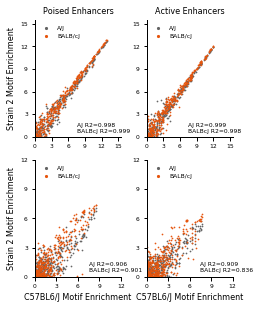

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(90/mm_conv,120/mm_conv))
plt.subplots_adjust(hspace=0.2, wspace=0.3)


# ATAC general motifs
axs[0,0].scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['AJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[0,0].scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['BALBcJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)

#set max and min
axs[0,0].set_xlim([0,ax_max]);
axs[0,0].set_ylim([0,ax_max]);

# set title
axs[0,0].set_title('Poised Enhancers',
                   fontsize=8)

axs[0,0].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[0,0].set_xticks(np.arange(0,ax_max,tickstep));
axs[0,0].set_xticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[0,0].set_yticks(np.arange(0,ax_max,tickstep));
axs[0,0].set_yticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
# axs[0,0].set_xlabel('C57BL/6J Motif Enrichment', fontsize=label_font_size);
axs[0,0].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# set axis text
axs[0,0].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                            'AJ_poised_distal_enhancer_motifs'],
    atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                            'BALBcJ_poised_distal_enhancer_motifs']))


# ATAC strain specific motifs
axs[1,0].scatter(np.log2(-atac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-atac_differential_motif_pval_frame['aj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[1,0].scatter(np.log2(-atac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-atac_differential_motif_pval_frame['balbcj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)

#set max and min
axs[1,0].set_xlim([0,12]);
axs[1,0].set_ylim([0,12]);

# # set title
# axs[1,0].set_title('Strain Specific\nATAC-seq',
#                    fontsize=8)

axs[1,0].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[1,0].set_xticks(np.arange(0,13,tickstep));
axs[1,0].set_xticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[1,0].set_yticks(np.arange(0,13,tickstep));
axs[1,0].set_yticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
axs[1,0].set_xlabel('C57BL6/J Motif Enrichment', fontsize=label_font_size);
axs[1,0].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate with r^2 values
axs[1,0].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    atac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'aj_intersection_distal_motifs_nobg_nodenovo'],
    atac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'balbcj_intersection_distal_motifs_nobg_nodenovo']))

# H3K27Ac general motifs
axs[0,1].scatter(np.log2(-h3k27ac_active_motif_pval_frame['C57Bl6J_active_distal_enhancer_motifs']+1),
           np.log2(-h3k27ac_active_motif_pval_frame['AJ_active_distal_enhancer_motifs']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[0,1].scatter(np.log2(-h3k27ac_active_motif_pval_frame['C57Bl6J_active_distal_enhancer_motifs']+1),
           np.log2(-h3k27ac_active_motif_pval_frame['BALBcJ_active_distal_enhancer_motifs']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)

#set max and min
axs[0,1].set_xlim([0,ax_max]);
axs[0,1].set_ylim([0,ax_max]);

# set title
axs[0,1].set_title('Active Enhancers',
                   fontsize=8)

axs[0,1].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[0,1].set_xticks(np.arange(0,ax_max,tickstep));
axs[0,1].set_xticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[0,1].set_yticks(np.arange(0,ax_max,tickstep));
axs[0,1].set_yticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
# axs[0,1].set_xlabel('C57BL/6J Motif Enrichment', fontsize=label_font_size);
# axs[0,1].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate with r^2 values
axs[0,1].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    h3k27ac_active_motif_pval_frame.corr().loc['C57Bl6J_active_distal_enhancer_motifs',
                                               'AJ_active_distal_enhancer_motifs'],
    h3k27ac_active_motif_pval_frame.corr().loc['C57Bl6J_active_distal_enhancer_motifs',
                                               'BALBcJ_active_distal_enhancer_motifs']))

# H3K27Ac strain specific motifs
axs[1,1].scatter(np.log2(-h3k27ac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-h3k27ac_differential_motif_pval_frame['aj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[1,1].scatter(np.log2(-h3k27ac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-h3k27ac_differential_motif_pval_frame['balbcj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)

#set max and min
axs[1,1].set_xlim([0,12]);
axs[1,1].set_ylim([0,12]);

# # set title
# axs[1,1].set_title('Strain Spec.\nH3K27Ac ChIP-seq',
#                    fontsize=8)

axs[1,1].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[1,1].set_xticks(np.arange(0,13,tickstep));
axs[1,1].set_xticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[1,1].set_yticks(np.arange(0,13,tickstep));
axs[1,1].set_yticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
axs[1,1].set_xlabel('C57BL6/J Motif Enrichment', fontsize=label_font_size);
# axs[1,1].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate with r^2 values
axs[1,1].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    h3k27ac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'aj_intersection_distal_motifs_nobg_nodenovo'],
    h3k27ac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'balbcj_intersection_distal_motifs_nobg_nodenovo']))

plt.savefig('./motif_correlation/atac_h3k27ac_motif_corr.pdf',
            dpi=500,
            bbox_inches='tight')

Corr: 
* Poised Distal:
    * AJ - C57: 0.997
    * BALBcJ - C57: 0.987
* Active Distal:
    * AJ - C57: 0.985
    * BALBcJ - C57: 0.986
* ATAC Differential:
    * AJ - C57: 0.906
    * BALBcJ - C57: 0.901
* H3K27Ac Differential:
    * AJ - C57: 0.909
    * BALBcJ - C57: 0.835

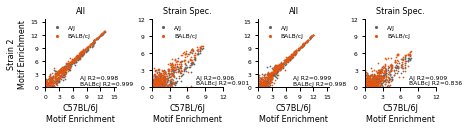

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(7,1.25))
plt.subplots_adjust(hspace=0.2, wspace=0.5)


# ATAC general motifs
axs[0].scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['AJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[0].scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['BALBcJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

#set max and min
axs[0].set_xlim([0,ax_max]);
axs[0].set_ylim([0,ax_max]);

# set title
axs[0].set_title('All', fontsize=8)

axs[0].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[0].set_xticks(np.arange(0,ax_max,tickstep));
axs[0].set_xticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[0].set_yticks(np.arange(0,ax_max,tickstep));
axs[0].set_yticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
axs[0].set_xlabel('C57BL/6J\nMotif Enrichment', fontsize=label_font_size);
axs[0].set_ylabel('Strain 2\nMotif Enrichment', fontsize=label_font_size);

# set axis text
axs[0].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                            'AJ_poised_distal_enhancer_motifs'],
    atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                            'BALBcJ_poised_distal_enhancer_motifs']))


# ATAC strain specific motifs
axs[1].scatter(np.log2(-atac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-atac_differential_motif_pval_frame['aj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[1].scatter(np.log2(-atac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-atac_differential_motif_pval_frame['balbcj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

#set max and min
axs[1].set_xlim([0,12]);
axs[1].set_ylim([0,12]);

# # set title
axs[1].set_title('Strain Spec.', fontsize=8)


axs[1].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[1].set_xticks(np.arange(0,13,tickstep));
axs[1].set_xticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[1].set_yticks(np.arange(0,13,tickstep));
axs[1].set_yticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
axs[1].set_xlabel('C57BL/6J\nMotif Enrichment', fontsize=label_font_size);
# axs[1].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate with r^2 values
axs[1].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    atac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'aj_intersection_distal_motifs_nobg_nodenovo'],
    atac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'balbcj_intersection_distal_motifs_nobg_nodenovo']))

# H3K27Ac general motifs
axs[2].scatter(np.log2(-h3k27ac_active_motif_pval_frame['C57Bl6J_active_distal_enhancer_motifs']+1),
           np.log2(-h3k27ac_active_motif_pval_frame['AJ_active_distal_enhancer_motifs']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[2].scatter(np.log2(-h3k27ac_active_motif_pval_frame['C57Bl6J_active_distal_enhancer_motifs']+1),
           np.log2(-h3k27ac_active_motif_pval_frame['BALBcJ_active_distal_enhancer_motifs']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

#set max and min
axs[2].set_xlim([0,ax_max]);
axs[2].set_ylim([0,ax_max]);

# set title
axs[2].set_title('All', fontsize=8)

axs[2].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[2].set_xticks(np.arange(0,ax_max,tickstep));
axs[2].set_xticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[2].set_yticks(np.arange(0,ax_max,tickstep));
axs[2].set_yticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
axs[2].set_xlabel('C57BL/6J\nMotif Enrichment', fontsize=label_font_size);
# axs[2].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate with r^2 values
axs[2].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    h3k27ac_active_motif_pval_frame.corr().loc['C57Bl6J_active_distal_enhancer_motifs',
                                               'AJ_active_distal_enhancer_motifs'],
    h3k27ac_active_motif_pval_frame.corr().loc['C57Bl6J_active_distal_enhancer_motifs',
                                               'BALBcJ_active_distal_enhancer_motifs']))

# H3K27Ac strain specific motifs
axs[3].scatter(np.log2(-h3k27ac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-h3k27ac_differential_motif_pval_frame['aj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#636363',
           label='A/J')
axs[3].scatter(np.log2(-h3k27ac_differential_motif_pval_frame['c57bl6j_intersection_distal_motifs_nobg_nodenovo']+1),
           np.log2(-h3k27ac_differential_motif_pval_frame['balbcj_intersection_distal_motifs_nobg_nodenovo']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
axs[3].spines['right'].set_visible(False)
axs[3].spines['top'].set_visible(False)

#set max and min
axs[3].set_xlim([0,12]);
axs[3].set_ylim([0,12]);

# set title
axs[3].set_title('Strain Spec.', fontsize=8)

axs[3].legend(markerscale=3,
          loc='upper left',
          fontsize=6,
          frameon=False)

# set ticks
axs[3].set_xticks(np.arange(0,13,tickstep));
axs[3].set_xticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);
axs[3].set_yticks(np.arange(0,13,tickstep));
axs[3].set_yticklabels(np.arange(0,13,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
axs[3].set_xlabel('C57BL/6J\nMotif Enrichment', fontsize=label_font_size);
# axs[3].set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate with r^2 values
axs[3].text(7.5, 0.5, 'AJ R2=%.3f\nBALBcJ R2=%.3f' % (
    h3k27ac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'aj_intersection_distal_motifs_nobg_nodenovo'],
    h3k27ac_differential_motif_pval_frame.corr().loc['c57bl6j_intersection_distal_motifs_nobg_nodenovo',
                                                  'balbcj_intersection_distal_motifs_nobg_nodenovo']))

plt.savefig('./motif_correlation/atac_h3k27ac_motif_corr_wide.pdf',
            dpi=500,
            bbox_inches='tight')

# ATAC-only

In [23]:
motifs = ['PU.1(ETS)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer',
          'IRF8(IRF)/BMDM-IRF8-ChIP-Seq(GSE77884)/Homer']
labels = ['PU.1',
          'IRF8']

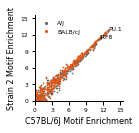

In [24]:
fig, ax = plt.subplots(figsize=(40/mm_conv,40/mm_conv))

ax.scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['AJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='#636363',
           label='A/J')
ax.scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['BALBcJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='#e6550d',
           label='BALB/cJ')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#set max and min
ax.set_xlim([0,ax_max]);
ax.set_ylim([0,ax_max]);

ax.legend(markerscale=3,
          frameon=False)

# set ticks
ax.set_xticks(np.arange(0,ax_max,tickstep));
ax.set_xticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);
ax.set_yticks(np.arange(0,ax_max,tickstep));
ax.set_yticklabels(np.arange(0,ax_max,tickstep, dtype=int), fontsize=ticklabel_font_size);

# set axis labels
ax.set_xlabel('C57BL/6J Motif Enrichment', fontsize=label_font_size);
ax.set_ylabel('Strain 2 Motif Enrichment', fontsize=label_font_size);

# annotate
for motif, label in zip(motifs, labels):
    ax.text(np.log2(-atac_poised_motif_pval_frame.loc[motif, 'C57Bl6J_poised_distal_enhancer_motifs']),
            np.log2(-atac_poised_motif_pval_frame.loc[motif, 'AJ_poised_distal_enhancer_motifs']),
            s=label)

# ax.text(np.log2(-atac_poised_motif_pval_frame.loc[motif, 'C57Bl6J_poised_distal_enhancer_motifs']),
#         np.log2(-atac_poised_motif_pval_frame.loc[motif, 'BALBcJ_poised_distal_enhancer_motifs']),
#         s=label)

plt.savefig('./motif_correlation/atac_only_test.pdf',
            dpi=500,
            bbox_inches='tight')

In [13]:
-atac_poised_motif_pval_frame.loc[motif, 'C57Bl6J_poised_distal_enhancer_motifs']

7706.0

# plot separately (probably a waste of space)

Text(0, 12, 'R^2=1.00')

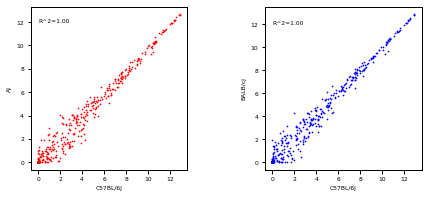

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
plt.subplots_adjust(wspace=.5)
ax1.scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['AJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='r')
ax1.set_xlabel('C57BL/6J')
ax1.set_ylabel('AJ')
ax1.text(0,12,
         'R^2=%.2f' % atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                                    'AJ_poised_distal_enhancer_motifs']**2)

ax2.scatter(np.log2(-atac_poised_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-atac_poised_motif_pval_frame['BALBcJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='b')
ax2.set_xlabel('C57BL/6J')
ax2.set_ylabel('BALB/cJ')
ax2.text(0,12,
         'R^2=%.2f' % atac_poised_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                                    'BALBcJ_poised_distal_enhancer_motifs']**2)